In [1]:
!pip list |grep jij
!pip list |grep qiskit

jij-cimod                1.4.53
jijbench                 0.5.8
jijmodeling              0.13.2
jijmodeling-schema       0.2.0
jijmodeling-transpiler   0.5.1
jijzept                  1.15.3
openjij                  0.6.16

[notice] A new release of pip is available: 23.1.1 -> 23.2
[notice] To update, run: pip install --upgrade pip
pytket-qiskit            0.37.1
qiskit                   0.43.2
qiskit-aer               0.12.1
qiskit-ibm-provider      0.5.2
qiskit-ibm-runtime       0.8.0
qiskit-ibmq-provider     0.20.2
qiskit-optimization      0.5.0
qiskit-terra             0.24.1
quri-parts-qiskit        0.11.0

[notice] A new release of pip is available: 23.1.1 -> 23.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import jijmodeling as jm
import jijmodeling.transpiler as jmt
from jijtranspiler_qiskit.qaoa import transpile_to_qaoa_ansatz_quri
from jijtranspiler_qiskit.qaoa import transpile_to_qaoa_ansatz

import qiskit as qk
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'jijtranspiler_qiskit'

In [2]:
# define variables
d = jm.Placeholder('d', dim=2)
N = d.shape[0].set_latex("N")
i = jm.Element('i', (0, N))
j = jm.Element('j', (0, N))
t = jm.Element('t', (0, N))
x = jm.Binary('x', shape=(N, N))

# set problem
problem = jm.Problem('TSP')
problem += jm.Sum([i, j], d[i, j] * jm.Sum(t, x[i, t]*x[j, (t+1) % N]))
problem += jm.Constraint("one-city", jm.Sum(i,x[i, t]) == 1, forall=t)
problem += jm.Constraint("one-time", jm.Sum(t,x[i, t]) == 1, forall=i)
problem

/tmp/ipykernel_1823079/24099923.py:2: JijFutureWarning: The argument `dim` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `ndim` instead.
  d = jm.Placeholder('d', dim=2)
/tmp/ipykernel_1823079/24099923.py:4: JijFutureWarning: `Element` takes 1 positional arguments in jijmodeling 1.x.x. Please use keyword arguments for extra arguments.
  i = jm.Element('i', (0, N))
/tmp/ipykernel_1823079/24099923.py:5: JijFutureWarning: `Element` takes 1 positional arguments in jijmodeling 1.x.x. Please use keyword arguments for extra arguments.
  j = jm.Element('j', (0, N))
/tmp/ipykernel_1823079/24099923.py:6: JijFutureWarning: `Element` takes 1 positional arguments in jijmodeling 1.x.x. Please use keyword arguments for extra arguments.
  t = jm.Element('t', (0, N))
/tmp/ipykernel_1823079/24099923.py:7: JijFutureWarning: The class `Binary` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `BinaryVar` instead.
  x = jm.Binary('x', shape=

In [3]:
def generate_random_instance(n):
    x_pos = np.random.rand(n)
    y_pos = np.random.rand(n)
    XX, XX_T = np.meshgrid(x_pos, x_pos)
    YY, YY_T = np.meshgrid(y_pos, y_pos)
    distance = np.sqrt((XX - XX_T) ** 2 + (YY - YY_T) ** 2)
    return x_pos, y_pos, distance

In [4]:
x_pos, y_pos, distance = generate_random_instance(3)

In [5]:
# x_pos=np.array([0.05075598, 0.20874418, 0.68428089])
# y_pos=np.array([0.90228199, 0.17221228, 0.68177534])
# distance=np.array([[0.        , 0.74696858, 0.67080325],
#         [0.74696858, 0.        , 0.69698614],
#         [0.67080325, 0.69698614, 0.        ]])

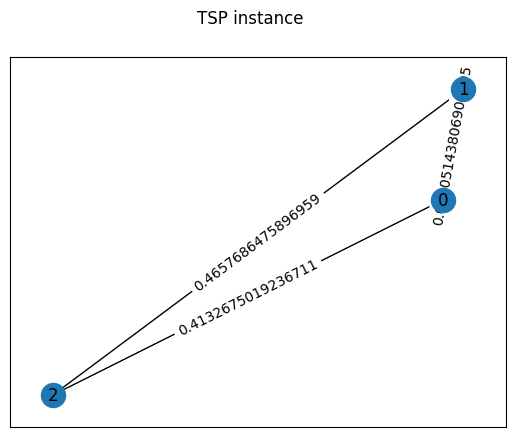

In [6]:
from jijbench.visualization.figure.graph import Graph, GraphType

graph = Graph.from_distance_matrix(distance,graphtype=GraphType.UNDIRECTED)
node_pos = {i:(x,y) for i,(x,y) in enumerate(zip(x_pos,y_pos))}
graph.show(node_pos=node_pos,title="TSP instance")

In [7]:
compiled_instance = jmt.core.compile_model(problem, {"d": distance})

In [8]:
qaoa_builder = transpile_to_qaoa_ansatz_quri(compiled_instance, relax_method = jmt.core.pubo.RelaxationMethod.SquaredPenalty)

# You can also use Augumented Lagrangian method to build QUBO
# qaoa_builder = transpile_to_qaoa_ansatz(compiled_instance, relax_method = jmt.core.pubo.RelaxationMethod.AugmentedLagrangian)

In [9]:
ising_operator, constant= qaoa_builder.get_hamiltonian(detail_parameters = {'one-city':{(1,): (2, 1)},'one-time':{(1,): (2, 1)}})

In [10]:
qaoa_ansatz, hamiltonian, constant = qaoa_builder.get_qaoa_ansatz(p=1,multipliers = {'one-city':1,'one-time':1})

[[0, 1], [2, 3], [4, 5], [0, 6], [2, 7], [4, 8], [2, 5], [1, 4], [0, 3], [5, 6], [1, 7], [3, 8], [2, 8], [4, 6], [0, 7], [1, 8], [3, 6], [5, 7], [5, 8], [0, 8], [0, 5], [1, 6], [2, 6], [1, 2], [3, 7], [4, 7], [3, 4], [2, 4], [0, 4], [0, 2], [1, 3], [3, 5], [1, 5], [6, 7], [7, 8], [6, 8]]
([0], -1.5338690598500464)
([1], -1.5902287417841061)
([2], -1.5338690598500464)
([3], -1.5902287417841061)
([4], -1.5338690598500464)
([5], -1.5902287417841061)
([6], -1.9436403180659403)
([7], -1.9436403180659403)
([8], -1.9436403180659403)
([0, 1], 0.04511437089205304)
([2, 3], 0.04511437089205304)
([4, 5], 0.04511437089205304)
([0, 6], 0.22182015903297017)
([2, 7], 0.22182015903297017)
([4, 8], 0.22182015903297017)
([2, 5], 0.04511437089205304)
([1, 4], 0.04511437089205304)
([0, 3], 0.04511437089205304)
([5, 6], 0.25)
([1, 7], 0.25)
([3, 8], 0.25)
([2, 8], 0.22182015903297017)
([4, 6], 0.22182015903297017)
([0, 7], 0.22182015903297017)
([1, 8], 0.25)
([3, 6], 0.25)
([5, 7], 0.25)
([5, 8], 0.5)
([0,

In [11]:
print("Qubit count:", qaoa_ansatz.qubit_count)
print("Circuit depth:", qaoa_ansatz.depth)

# A parametric circuit object does not have .gates property.

print("Parameter count:", qaoa_ansatz.parameter_count)


Qubit count: 9
Circuit depth: 39
Parameter count: 2


Now that the qiskit QAOA circuit has been obtained, programming can be carried out using qiskit from this point onwards.

# Run QAOA

In [47]:
from scipy.optimize import minimize
from qulacs import QuantumState, QuantumCircuit, Observable, PauliOperator
from quri_parts.qulacs.circuit import convert_circuit as convert_circuit_qulacs
from quri_parts.core.state import ParametricCircuitQuantumState
from math import pi
import qulacs

def QAOA_output_onelayer(x):
    bind_qaoa_ansatz=qaoa_ansatz.bind_parameters(x)
    qulacs_circuit = convert_circuit_qulacs(bind_qaoa_ansatz)

    qulacs_state = qulacs.QuantumState(9)
    qulacs_circuit.update_quantum_state(qulacs_state)
    return cost_observable.get_expectation_value(qulacs_state)

n = 9

param_state = ParametricCircuitQuantumState(n, qaoa_ansatz)

# C(Z)をqulacs.Observableとして定義
cost_observable = Observable(n)
for i in range(n):
    cost_observable.add_operator( PauliOperator("Z {:} ".format(i), 1) )
    
## 初期値
x0 = np.array([1, 1])
optimization_history=[]
## scipy.minimize を用いて最小化
result = minimize(QAOA_output_onelayer,
                  x0, options={'maxiter':1000},
                  method='COBYLA',
                  callback = lambda x:optimization_history.append(QAOA_output_onelayer(x)))
print(result.fun) # 最適化後の値
print(result.x) # 最適化後の(beta, gamma)

-0.3450134992768346
[2.54938632 0.78542559]


Text(0, 0.5, 'cost function')

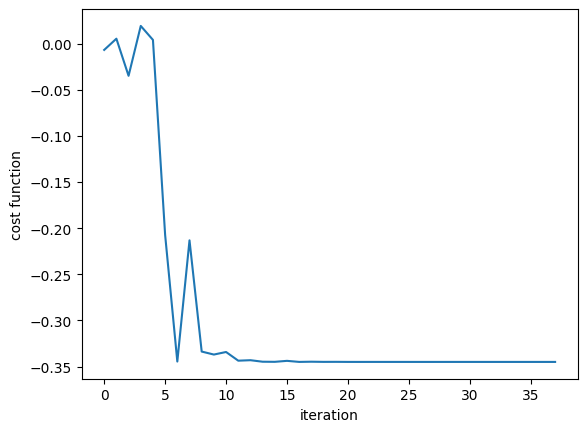

In [48]:
plt.plot(optimization_history)
plt.xlabel('iteration')
plt.ylabel('cost function')

In [49]:
# 最適なbeta, gammaを使って |beta, gamma> をつくる
beta_opt, gamma_opt = result.x
# beta_opt, gamma_opt = [2.7063137,0.22769546]
bind_qaoa_ansatz_opt=qaoa_ansatz.bind_parameters([beta_opt, gamma_opt])
# bind_qaoa_ansatz_opt=qaoa_ansatz.bind_parameters(result.x)
qulacs_circuit_opt = convert_circuit_qulacs(bind_qaoa_ansatz_opt)

qulacs_state = qulacs.QuantumState(n)
qulacs_circuit_opt.update_quantum_state(qulacs_state)

print(QAOA_output_onelayer([beta_opt, gamma_opt]))

probs = np.abs(qulacs_state.get_vector())**2

-0.3450134992768346


In [50]:
# from quri_parts.qiskit.circuit import convert_circuit
# Qiskit_circuit=convert_circuit(bind_qaoa_ansatz_opt)
# Qiskit_circuit.draw("mpl")

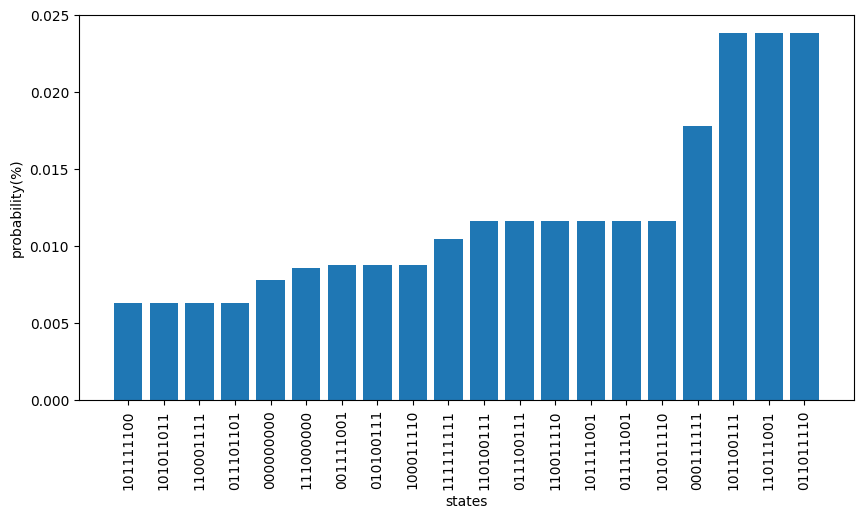

In [51]:
# プロットする
import matplotlib.pyplot as plt
%matplotlib inline

## z方向に射影測定した時に得られる可能性があるビット列
z_basis = [format(i,"b").zfill(n) for i in range(len(probs))]

top_10_indices = np.argsort(probs)[-20:]

# Create new arrays with only the top 10 max probabilities
top_10_probs = probs[top_10_indices]
top_10_z_basis = np.array(z_basis)[top_10_indices]

plt.figure(figsize=(10, 5))
plt.xlabel("states")
plt.ylabel("probability(%)")
plt.bar(top_10_z_basis, top_10_probs)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()

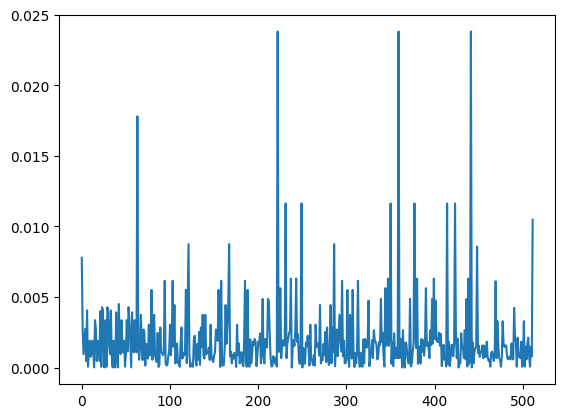

In [52]:
list_k=[]
qist_dict = {i: value for i, value in enumerate(probs)}
for i in qist_dict.items():
    list_k.append(i[1])
plt.plot(qist_dict.keys(),list_k)

In [53]:
decoded_results = qaoa_builder.decode_from_probs(probs)
# qaoa_builder.decode_from_counts()
print(decoded_results)

SampleSet(record=Record(solution={'x': [(([], []), [], (3, 3)), (([2], [0]), [1], (3, 3)), (([2], [2]), [1], (3, 3)), (([2, 2], [2, 0]), [1, 1], (3, 3)), (([2], [1]), [1], (3, 3)), (([2, 2], [1, 0]), [1, 1], (3, 3)), (([2, 2], [1, 2]), [1, 1], (3, 3)), (([2, 2, 2], [1, 2, 0]), [1, 1, 1], (3, 3)), (([1], [0]), [1], (3, 3)), (([1, 2], [0, 0]), [1, 1], (3, 3)), (([1, 2], [0, 2]), [1, 1], (3, 3)), (([1, 2, 2], [0, 2, 0]), [1, 1, 1], (3, 3)), (([1, 2], [0, 1]), [1, 1], (3, 3)), (([1, 2, 2], [0, 1, 0]), [1, 1, 1], (3, 3)), (([1, 2, 2], [0, 1, 2]), [1, 1, 1], (3, 3)), (([1, 2, 2, 2], [0, 1, 2, 0]), [1, 1, 1, 1], (3, 3)), (([0], [2]), [1], (3, 3)), (([0, 2], [2, 0]), [1, 1], (3, 3)), (([0, 2], [2, 2]), [1, 1], (3, 3)), (([0, 2, 2], [2, 2, 0]), [1, 1, 1], (3, 3)), (([0, 2], [2, 1]), [1, 1], (3, 3)), (([0, 2, 2], [2, 1, 0]), [1, 1, 1], (3, 3)), (([0, 2, 2], [2, 1, 2]), [1, 1, 1], (3, 3)), (([0, 2, 2, 2], [2, 1, 2, 0]), [1, 1, 1, 1], (3, 3)), (([0, 1], [2, 0]), [1, 1], (3, 3)), (([0, 1, 2], [2, 0

In [54]:
feasible_result = decoded_results.feasible()
feasible_result.to_dense()

SampleSet(record=Record(solution={'x': [array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]]), array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]]), array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]]), array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]]), array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]]), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])]}, num_occurrences=[0, 7, 1, 5, 37, 11]), evaluation=Evaluation(energy=None, objective=[0.963087587582373, 0.963087587582373, 0.963087587582373, 0.963087587582373, 0.963087587582373, 0.963087587582373], constraint_violations={'one-city': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'one-time': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, penalty={}), measuring_time=MeasuringTime(solve=SolvingTime(preprocess=None, solve=None, postprocess=None), system=SystemTime(post_problem_and_instance_data=None, request_queue=None, fetch_problem_and_instance_data=None, fetch_result=None, deserialize_solu

In [55]:
import networkx as nx
def plot_tour(ax,G,node_pos):
    nx.draw_networkx_nodes(
            G=G,
            pos=node_pos,
            ax=ax,
        )
    nx.draw_networkx_edges(
            G=G,
            pos=node_pos,
            ax=ax,
        )
    node_labels = {node: str(node) for node in G.nodes}
    nx.draw_networkx_labels(
            G=G,
            pos=node_pos,
            labels=node_labels,
            ax=ax,
        )

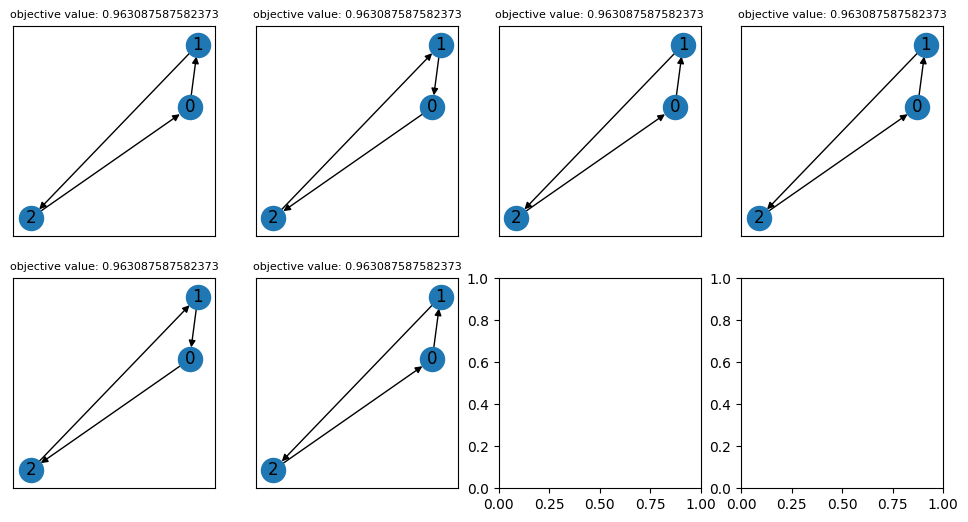

In [56]:
# 画像を横に並べるための設定
num_images = len(feasible_result)
columns = 4  # 一行に表示する画像の数
rows = (num_images - 1) // columns + 1  # 行数の計算

# 画像を横並びに表示するためのサブプロットの設定
fig, axes = plt.subplots(rows, columns, figsize=(12, 3*rows))

for i, objective_value in enumerate(feasible_result.evaluation.objective):
    ax = axes[i // columns, i % columns] 
    (time_order, route), value,matrix_shape = decoded_results.feasible().record.solution['x'][i]
    edge = [[route[i],route[i+1]] for i in range(len(route)-1)] + [[route[-1],route[0]]]
    graph = Graph.from_edge_list(edge_list=edge,graphtype=GraphType.DIRECTED)
    plot_tour(ax=ax,G=graph.G,node_pos=node_pos)
    ax.set_title(f"objective value: {objective_value}",fontsize=8)